In [60]:
import pandas as pd
import pickle,os, copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
import scipy
import seaborn as sns

import re

import margin_flatness as mf
import margin_flatness.postprocessing as mf_post


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
plt.rcParams["figure.figsize"] = (13,9)

COLORS = plt.cm.tab20(np.arange(20))

CORRECT_COLOR_IDX = 3
INCORRECT_COLOR_IDX = 1

In [62]:
root_folder = os.environ["PATH_TO_DEEP_FOLDER"]
data_name = "MNIST"

ce_exp = "CE_F1"
ce_experiment_folder = os.path.join(root_folder, "experiments", data_name, ce_exp)

mse_exp = "MSE_F1"
mse_experiment_folder = os.path.join(root_folder, "experiments", data_name, mse_exp)


In [63]:
ce_stats_df = mf_post.stats_plotting.get_end_stats(ce_experiment_folder, step=-1)
mse_stats_df = mf_post.stats_plotting.get_end_stats(mse_experiment_folder, step=-1)


In [64]:
ce_stats_df.sort_values(by="Acc Test Mean", ascending=False)

,Loss Test Mean,Loss Train Mean,Acc Train Mean,Acc Test Mean,Acc Gap Mean,batch_train_size,learning_rate,seed,weight_decay
1605777199.6255481,0.055523,0.001748,0.999867,0.9847,-0.015167,32,0.01,0,0.0005
1605839859.6129062,0.056597,0.001824,0.999867,0.9845,-0.015367,32,0.01,5,0.0005
1605724651.0897503,0.055077,0.007480,0.998217,0.9842,-0.014017,32,0.1,0,0.0001
1605728268.265154,0.051580,0.006640,0.998417,0.9840,-0.014417,32,0.1,10,0.0001
1605754885.6487322,0.061488,0.001164,0.999983,0.9838,-0.016183,256,0.05,0,0.0005
...,...,...,...,...,...,...,...,...,...
1605720879.3374493,0.083767,0.028003,0.991567,0.9748,-0.016767,32,0.1,0,0
1605723063.3285263,0.093201,0.000512,1.000000,0.9745,-0.025500,1024,0.01,5,0
1605723451.315186,0.091434,0.027657,0.991200,0.9727,-0.018500,32,0.1,10,0
1605795553.9344513,0.090816,0.037907,0.989067,0.9721,-0.016967,32,0.1,5,0.0005


## Get cached data

In [81]:
ce_all_point_traces, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
ce_all_point_output_margins, _ = mf.save_load.load_cached_data(ce_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
mse_all_point_output_margins, _ = mf.save_load.load_cached_data(mse_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_18-53-57")

ce_all_point_loss, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_loss", step=-1, time_stamp="Apr06_14-28-19")
mse_all_point_loss, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_loss", step=-1, time_stamp="Apr06_14-39-59")

ce_all_point_output, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_output", step=-1, time_stamp="Apr06_14-55-45")
# c_all_point_output, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_output", step=-1, time_stamp="Apr06_14-52-51")

ce_inp_out_jacobian, _ = mf.save_load.load_cached_data(ce_experiment_folder, "inp_out_jacobian", step=-1, time_stamp="Dec03_12-51-30")
mse_inp_out_jacobian, _ = mf.save_load.load_cached_data(mse_experiment_folder, "inp_out_jacobian", step=-1, time_stamp="Apr07_19-34-03")

ce_test_acc, _ = mf.save_load.load_cached_data(ce_experiment_folder, "acc", step=-1)
mse_test_acc, _ = mf.save_load.load_cached_data(mse_experiment_folder, "acc", step=-1)


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="May04_19-32-41")
mse_all_point_loss, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_loss", step=-1, time_stamp="May04_19-25-04")
mse_all_point_traces2, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="May04_19-01-45")


mse_dict = {"traces": mse_all_point_traces, "losses": mse_all_point_loss, "margins": mse_all_point_output_margins, "jacobian": mse_inp_out_jacobian}
ce_dict = {"traces": ce_all_point_traces, "losses": ce_all_point_loss, "margins": ce_all_point_output_margins, "jacobian": ce_inp_out_jacobian}




In [82]:
mse_all_point_traces

{'1605750263.755094': {'0': [52122.52600097656,
   41022.422488328884,
   52575.419929504395,
   38612.72210015191,
   71773.26666135204,
   119475.15850694444,
   808.6321614583334,
   1668.51328125,
   44019.10090266047,
   -22478.203369140625,
   49197.11733863467,
   41605.18297526042,
   10656.473828125,
   53307.00781831287,
   29253.982108248198,
   -565.822265625,
   43819.38483344184,
   41561.36052876134,
   42394.980088975695,
   9491.8642578125,
   56058.73468338816,
   -6598.037109375,
   32198.521311205488,
   47398.15955171131,
   32527.605859375,
   -1658.33984375,
   45942.538875804225,
   37061.158176967074,
   50040.97204589844,
   -37507.6748046875,
   38086.029591064456,
   28994.0734655502,
   163160.72141927082,
   51228.642782521805,
   14183.84130859375,
   -10821.33154296875,
   5928.033203125,
   48320.548583984375,
   52090.42435495477,
   75802.04166666667,
   31035.09083557129,
   33168.55115182059,
   -44694.640625,
   37223.490141369046,
   10551.0214843

In [83]:
mse_all_point_traces2

{'1605750263.755094': {'0': [120.3553114467197,
   101.53609711783272,
   143.89778089523315,
   90.55370903015137,
   125.20915655656295,
   429.65560629367826,
   129.62003394535608,
   98.12147289276123,
   97.45942573547363,
   90.23910854708764,
   103.87910302044594,
   106.22624546873803,
   66.10255655875572,
   112.5166450076633,
   69.69889335632324,
   100.94174867517808,
   119.93761790882458,
   119.82370855040469,
   118.59886860847473,
   114.07447610899459,
   128.24152851104736,
   54.7594682188595,
   47.96043735391953,
   119.54734072318443,
   74.18665040057638,
   115.42640989476985,
   101.88952008415671,
   100.50973917090374,
   120.45333757400513,
   125.11964937158533,
   102.21005829520847,
   101.04793363298688,
   327.59190576975465,
   117.78886570649989,
   103.55793380737305,
   135.7227872212728,
   110.70658824128925,
   105.83582746065579,
   108.59901983087713,
   119.18362778883714,
   173.17466481526694,
   58.132965405782066,
   122.82321791215377

# Plot a histogram for kendall and isotonic R^2 value. 

## Plot histogram Kendall 

In [72]:
# get all kendalls

num_nets = 1

names = ["hessian_margins", "hessian_loss", "hessian_jacob"]


# ce_kendall_coeffs = {}
# for exp_id in ce_stats_df.index:
#     ce_kendall_coeffs[exp_id] = {}
#     for k1 in ce_dict.keys():
#         for k2 in ce_dict.keys():
#             ce_kendall_coeffs[exp_id]["{}_{}".format(k1, k2)] = 
#         hessian_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
#         ce_kendall_coeffs["hessian_margins"][exp_id] = mf_post.correlation.get_kendall(hessian_data, ce_all_point_output_margins[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
#         ce_kendall_coeffs["hessian_loss"][exp_id] = mf_post.correlation.get_kendall(hessian_data, ce_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
#         ce_kendall_coeffs["hessian_jacob"][exp_id] = mf_post.correlation.get_kendall(hessian_data, ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation

    
mse_kendall_coeffs = {n: {} for n in names}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        try:
            hessian_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        except:
            continue
#         mse_kendall_coeffs["hessian_margins"][exp_id] = mf_post.correlation.get_kendall(hessian_data, mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
        mse_kendall_coeffs["hessian_loss"][exp_id] = mf_post.correlation.get_kendall(hessian_data, mse_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
#         mse_kendall_coeffs["hessian_jacob"][exp_id] = mf_post.correlation.get_kendall(hessian_data, mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation


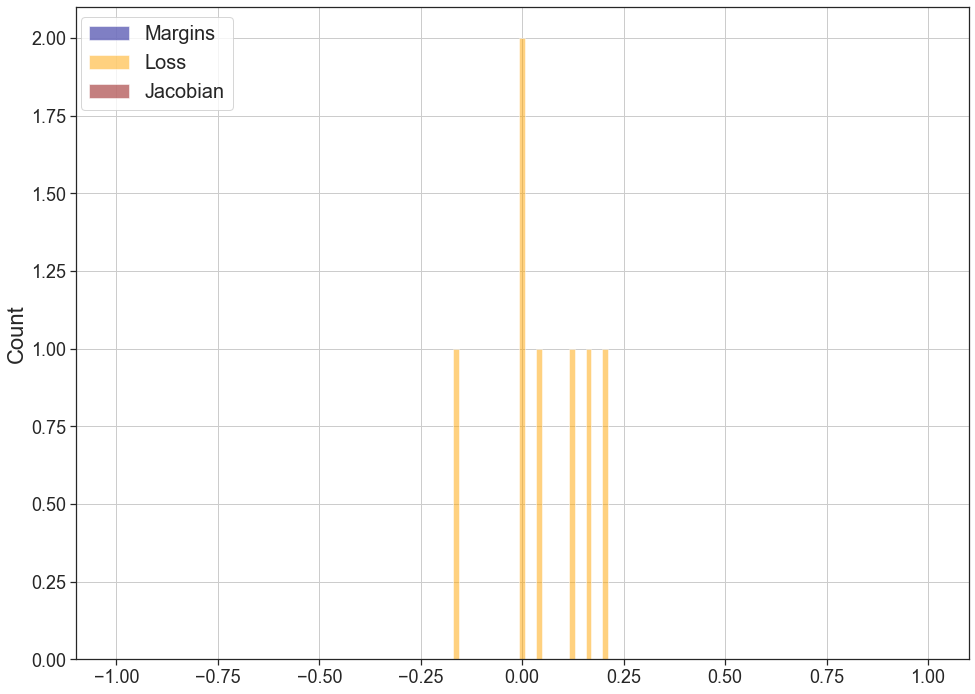

In [73]:
import seaborn as sns

data_type = "MSE"

if data_type == "MSE":
    dict_to_use = mse_kendall_coeffs
else:
    dict_to_use = ce_kendall_coeffs

names = ["hessian_margins", "hessian_loss", "hessian_jacob"]


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 0.33        ]
c2 = [1.        , 0.49803922, 0.05490196, 0.66       ]
c3 = [1.        , 0.49803922, 0.05490196, 1        ]

# c2 = [0.12156863, 0.46666667, 0.70588235,         ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([list(dict_to_use["hessian_margins"].values()), 
              list(dict_to_use["hessian_loss"].values()),
              list(dict_to_use["hessian_jacob"].values())], color=['darkblue','orange', 'darkred'], rwidth=5, bins=np.linspace(-1, 1, 50), alpha=0.5, label=["Margins", "Loss", "Jacobian"])



# sns.histplot(list(mse_kendall_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count",  label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

# ax1_hist.set_xlim([-1, 0.2])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.27, 0.88))



# f.savefig("../figs/kendall_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

## Plot R2 of isotopic

In [153]:

num_nets = 1

names = ["hessian_margins", "hessian_loss", "hessian_jacob"]


ce_r2_coeffs = {n: {} for n in names}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        hessian_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs["hessian_margins"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, ce_all_point_output_margins[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        ce_r2_coeffs["hessian_loss"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, ce_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        ce_r2_coeffs["hessian_jacob"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")

    
mse_r2_coeffs = {n: {} for n in names}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        hessian_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        mse_r2_coeffs["hessian_margins"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        mse_r2_coeffs["hessian_loss"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, mse_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        mse_r2_coeffs["hessian_jacob"][exp_id] = mf_post.correlation.get_isotonic_r_squared(hessian_data, mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

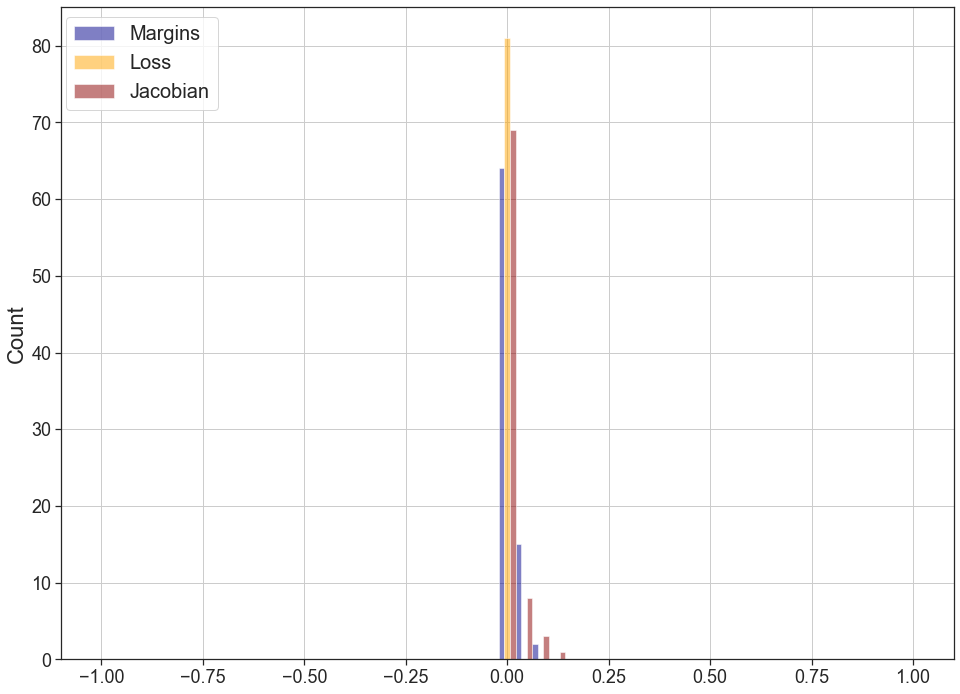

In [155]:
import seaborn as sns

data_type = "MSE"

if data_type == "MSE":
    dict_to_use = mse_r2_coeffs
else:
    dict_to_use = ce_r2_coeffs

names = ["hessian_margins", "hessian_loss", "hessian_jacob"]


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 0.33        ]
c2 = [1.        , 0.49803922, 0.05490196, 0.66       ]
c3 = [1.        , 0.49803922, 0.05490196, 1        ]

# c2 = [0.12156863, 0.46666667, 0.70588235,         ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([list(dict_to_use["hessian_margins"].values()), 
              list(dict_to_use["hessian_loss"].values()),
              list(dict_to_use["hessian_jacob"].values())], color=['darkblue','orange', 'darkred'], rwidth=5, bins=np.linspace(-1, 1, 50), alpha=0.5, label=["Margins", "Loss", "Jacobian"])



# sns.histplot(list(mse_kendall_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count",  label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

# ax1_hist.set_xlim([-1, 0.2])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.27, 0.88))



# f.savefig("../figs/r2_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

## Plot worst, medium and best (according to kendall)
TODO: add isotonic line

In [417]:

num_nets = 1

ce_kendall_coeffs = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation

mse_kendall_coeffs = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs[exp_id] = mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation


In [418]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

### For CE 

(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7ff775492550>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7ff77485a820>)

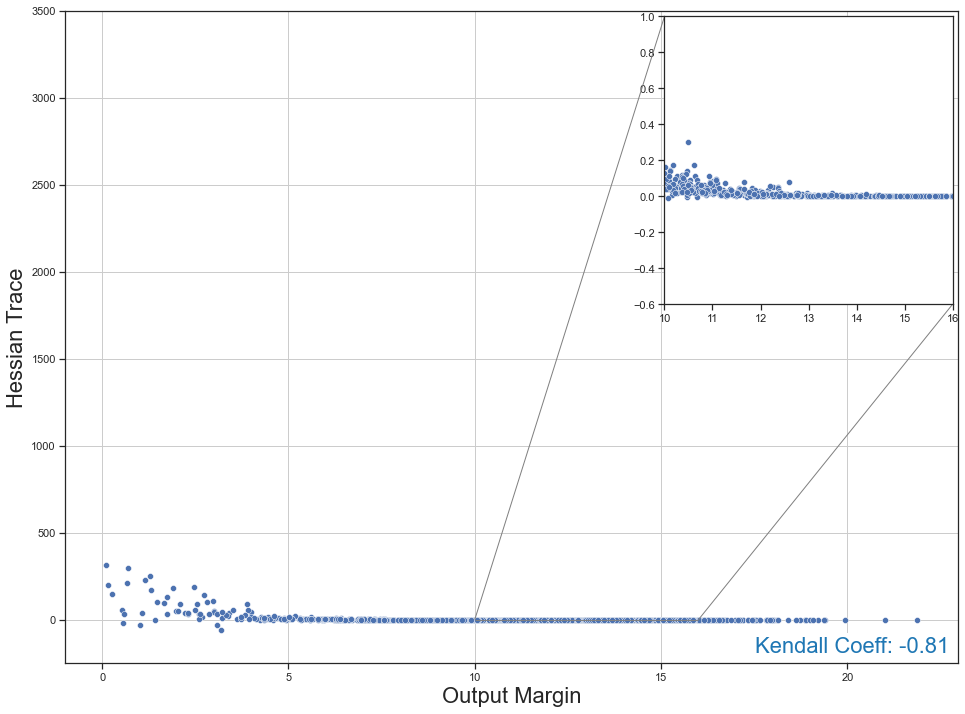

In [419]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(ce_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_all_point_output_margins[exp_id]["0"]
y_data = ce_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
ax1.set_ylim(-250, 3500)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

axins2 = inset_axes(ax1, width=4, height=4, loc=1)
sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# sub region of the original image
x1, x2, y1, y2 = 10, 16, -0.6, 1
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [420]:
mf_post.correlation.get_isotonic_r_squared(x_data, y_data, increasing=False)

0.7254748686094702

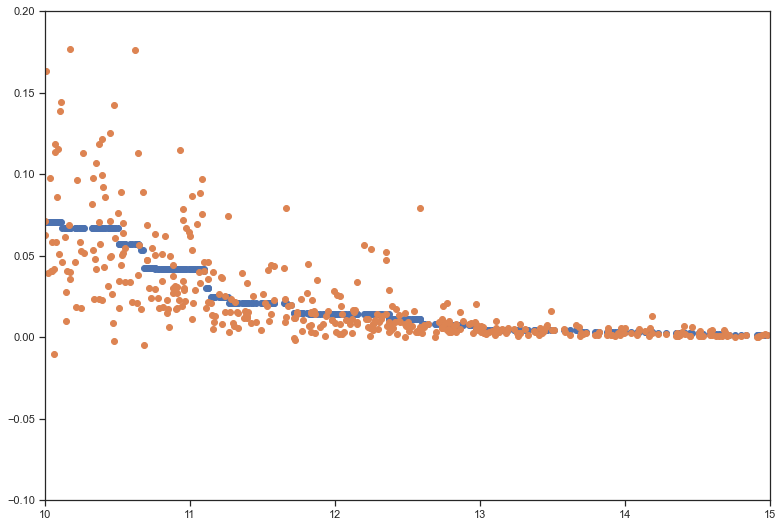

In [428]:
iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
y_predicted = iso_reg.predict(x_data)
plt.scatter(x_data, y_predicted)
plt.xlim(10, 15)
plt.ylim(-0.1, 0.2)
plt.scatter(x_data, y_data)

In [421]:
mf_post.correlation.get_isotonic_r_squared(y_data, x_data, increasing='auto')

0.855672185926985

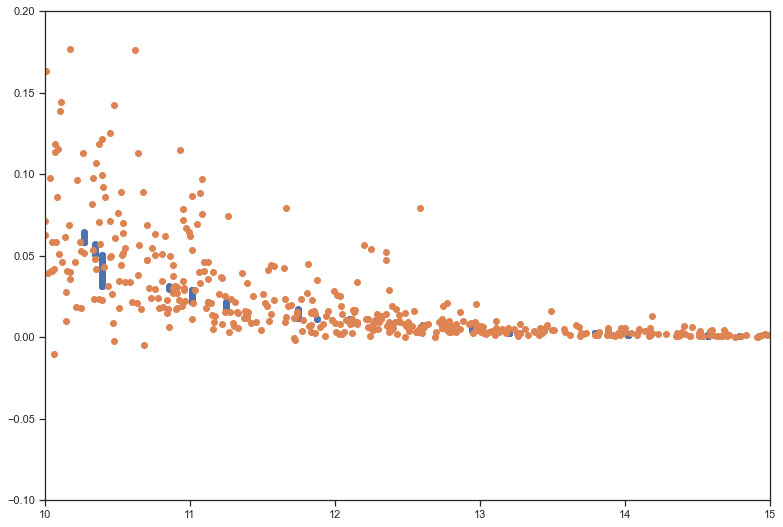

In [430]:
iso_reg = IsotonicRegression(increasing="auto").fit(y_data, x_data)
x_predicted = iso_reg.predict(y_data)
plt.xlim(10, 15)
plt.ylim(-0.1, 0.2)
plt.scatter(x_predicted, y_data)
plt.scatter(x_data, y_data)

### For MSE

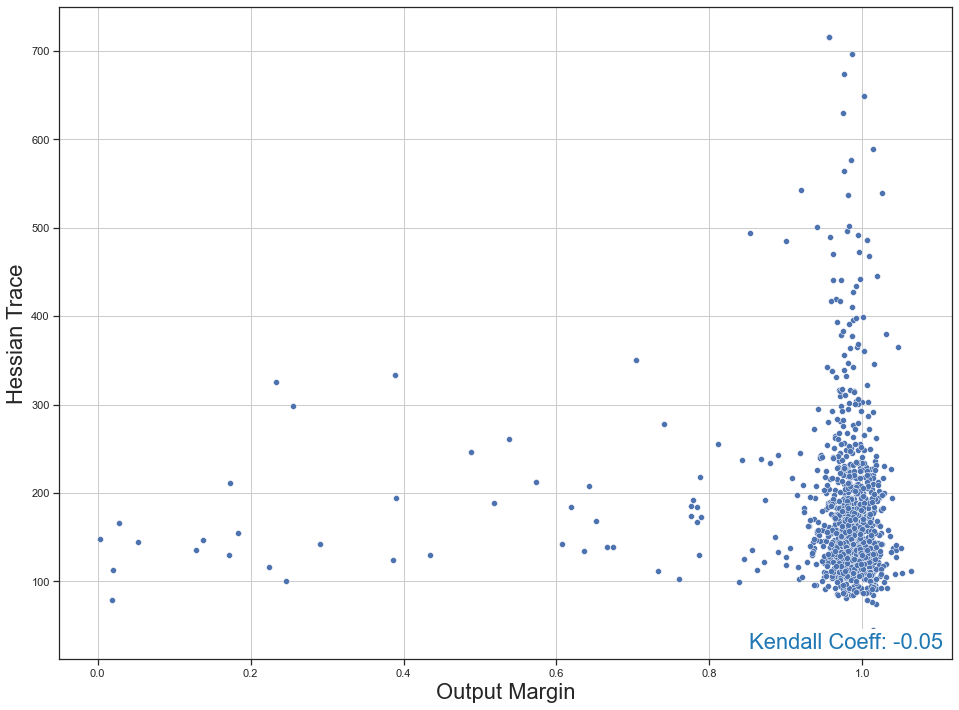

In [324]:
id_type = "best"

if id_type == "worst":
    exp_id, exp_kendall = min(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
elif id_type == "best":
    exp_id, exp_kendall = max(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))
else:
    exp_id, exp_kendall = sorted(mse_kendall_coeffs.items(), key=lambda kv: abs(kv[1]))[len(ce_kendall_coeffs)//2]

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_all_point_output_margins[exp_id]["0"]
y_data = mse_all_point_traces[exp_id]["0"]
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(-50, 300)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0.98, 1, 100, 500
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, mse_exp), dpi=300, bbox_inches = "tight",)

# Plot robustness comparisons with each other

## Plot Kendall

In [223]:

num_nets = 1

names = ["margins_loss", "margins_jacobian", "loss_jacobian"]


ce_kendall_coeffs = {n: {} for n in names}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        ce_kendall_coeffs["margins_loss"][exp_id] = mf_post.correlation.get_kendall(ce_all_point_unit_loss[exp_id]["{}".format(nn_idx)], ce_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
        ce_kendall_coeffs["margins_jacobian"][exp_id] = mf_post.correlation.get_kendall(ce_all_point_output_margins[exp_id]["{}".format(nn_idx)], ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
        ce_kendall_coeffs["loss_jacobian"][exp_id] = mf_post.correlation.get_kendall(ce_all_point_loss[exp_id]["{}".format(nn_idx)], ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation

    
mse_kendall_coeffs = {n: {} for n in names}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        mse_kendall_coeffs["margins_loss"][exp_id] = mf_post.correlation.get_kendall(mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], mse_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
        mse_kendall_coeffs["margins_jacobian"][exp_id] = mf_post.correlation.get_kendall(mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation
        mse_kendall_coeffs["loss_jacobian"][exp_id] = mf_post.correlation.get_kendall(mse_all_point_loss[exp_id]["{}".format(nn_idx)], mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True).correlation


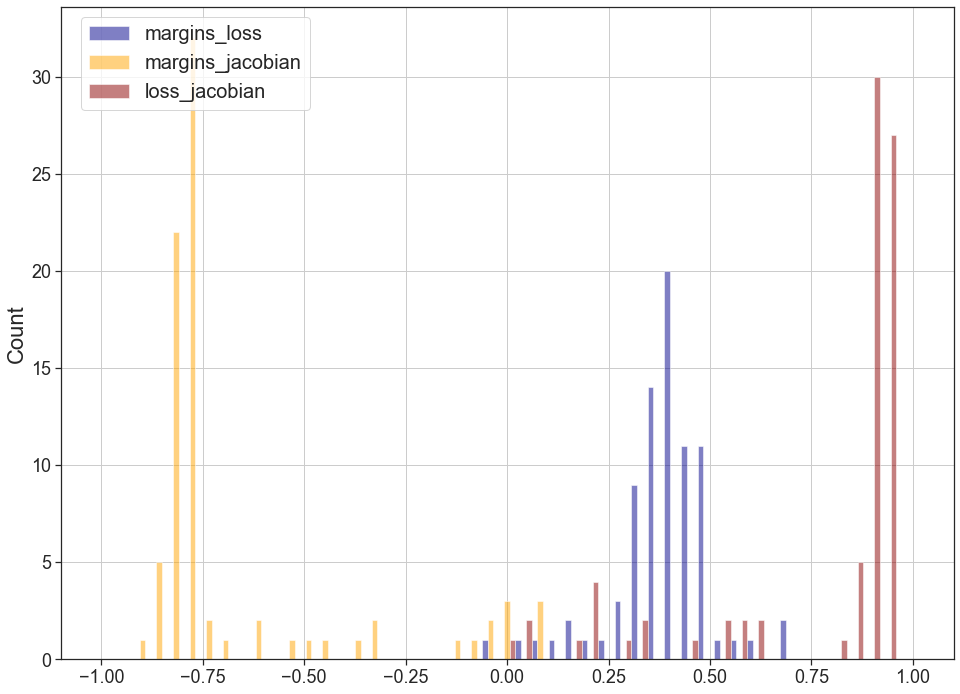

In [224]:
import seaborn as sns

data_type = "CE"

if data_type == "MSE":
    dict_to_use = mse_kendall_coeffs
else:
    dict_to_use = ce_kendall_coeffs


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 0.33        ]
c2 = [1.        , 0.49803922, 0.05490196, 0.66       ]
c3 = [1.        , 0.49803922, 0.05490196, 1        ]

# c2 = [0.12156863, 0.46666667, 0.70588235,         ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([list(dict_to_use["margins_loss"].values()), 
              list(dict_to_use["margins_jacobian"].values()),
              list(dict_to_use["loss_jacobian"].values())], color=['darkblue','orange', 'darkred'], rwidth=5, bins=np.linspace(-1, 1, 50), alpha=0.5, label=["margins_loss", "margins_jacobian", "loss_jacobian"])



# sns.histplot(list(mse_kendall_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count",  label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

# ax1_hist.set_xlim([-1, 0.2])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))



# f.savefig("../figs/kendall_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

## Plot R2

In [160]:

num_nets = 1

names = ["margins_loss", "margins_jacobian", "loss_jacobian"]


ce_r2_coeffs = {n: {} for n in names}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        ce_r2_coeffs["margins_loss"][exp_id] = mf_post.correlation.get_isotonic_r_squared(ce_all_point_output_margins[exp_id]["{}".format(nn_idx)], ce_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        ce_r2_coeffs["margins_jacobian"][exp_id] = mf_post.correlation.get_isotonic_r_squared(ce_all_point_output_margins[exp_id]["{}".format(nn_idx)], ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        ce_r2_coeffs["loss_jacobian"][exp_id] = mf_post.correlation.get_isotonic_r_squared(ce_all_point_loss[exp_id]["{}".format(nn_idx)], ce_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")

    
mse_r2_coeffs = {n: {} for n in names}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        mse_r2_coeffs["margins_loss"][exp_id] = mf_post.correlation.get_isotonic_r_squared(mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], mse_all_point_loss[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        mse_r2_coeffs["margins_jacobian"][exp_id] = mf_post.correlation.get_isotonic_r_squared(mse_all_point_output_margins[exp_id]["{}".format(nn_idx)], mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")
        mse_r2_coeffs["loss_jacobian"][exp_id] = mf_post.correlation.get_isotonic_r_squared(mse_all_point_loss[exp_id]["{}".format(nn_idx)], mse_inp_out_jacobian[exp_id]["{}".format(nn_idx)], remove_outliers=True, increasing="auto")


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

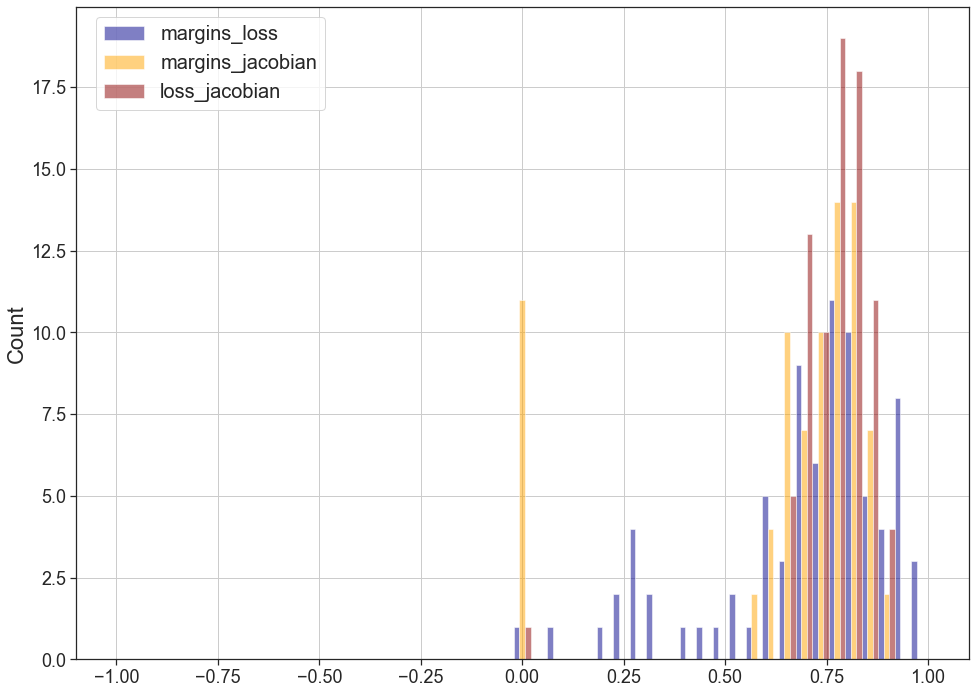

In [162]:
import seaborn as sns

data_type = "MSE"

if data_type == "MSE":
    dict_to_use = mse_r2_coeffs
else:
    dict_to_use = ce_r2_coeffs


sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 0.33        ]
c2 = [1.        , 0.49803922, 0.05490196, 0.66       ]
c3 = [1.        , 0.49803922, 0.05490196, 1        ]

# c2 = [0.12156863, 0.46666667, 0.70588235,         ]


f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([list(dict_to_use["margins_loss"].values()), 
              list(dict_to_use["margins_jacobian"].values()),
              list(dict_to_use["loss_jacobian"].values())], color=['darkblue','orange', 'darkred'], rwidth=5, bins=np.linspace(-1, 1, 50), alpha=0.5, label=["margins_loss", "margins_jacobian", "loss_jacobian"])



# sns.histplot(list(mse_kendall_coeffs.values()), ax=ax1_hist, color=c2, binwidth=0.02, stat="count",  label=mse_exp)


ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)



# sns.despine(ax=ax1_hist)

# ax1_hist.text(x=0.97, y=0.97, transform=ax1_hist.transAxes, s="Batch Size: 256 \n Skewness: {:.2f}".format(skewness1) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c1)

# ax1_hist.set_xlim([-1, 0.2])
ax1_hist.grid(b=True, which='major')

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))



# f.savefig("../figs/kendall_{}_{}_{}".format(data_name, ce_exp, mse_exp), dpi=300, bbox_inches = "tight",)

# Plot every point on one plot

In [182]:

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_all_x_data.append(x_data)
        ce_all_y_data.append(y_data)
#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
ce_all_x_data = np.array(ce_all_x_data).flatten()
ce_all_y_data = np.array(ce_all_y_data).flatten()
     

mse_all_x_data = []
mse_all_y_data = []
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_loss[exp_id]["{}".format(nn_idx)]
        mse_all_x_data.append(x_data)
        mse_all_y_data.append(y_data)
#         mse_all_x_data.append(np.mean(x_data))
#         mse_all_y_data.append(np.max(y_data))
        
mse_all_x_data = np.array(mse_all_x_data).flatten()
mse_all_y_data = np.array(mse_all_y_data).flatten()
     

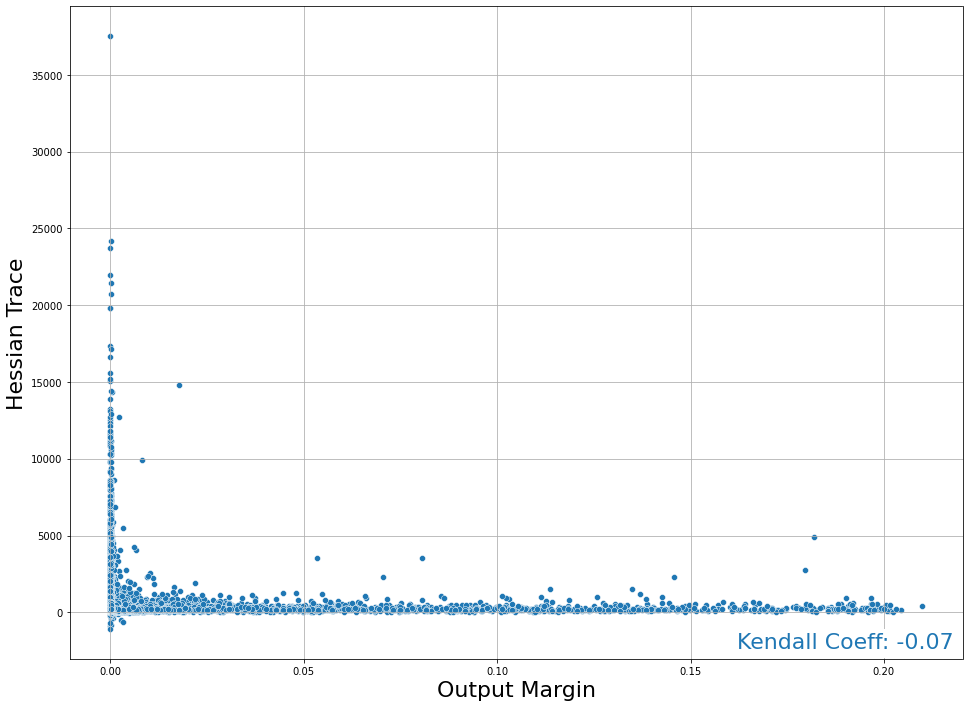

In [183]:
loss_type = "MSE"

if loss_type == "CE":
    exp_name = ce_exp
    x_data = ce_all_y_data
    y_data = ce_all_x_data
else:
    exp_name = mse_exp
    x_data = mse_all_y_data
    y_data = mse_all_x_data
    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(-50, 300)


ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(mf_post.correlation.get_kendall(y_data, x_data).correlation) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0.98, 1, 100, 500
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/all_points_{}_{}".format(exp_name, data_name), dpi=300, bbox_inches = "tight",)

### Using with Isotonic Regression

In [282]:

from sklearn.neighbors import LocalOutlierFactor

def get_outlier_filter(x_data, y_data):
    x_data, y_data = np.array(x_data), np.array(y_data)
    #     if len(x_data) < 5:
    #         return np.array([True]*len(x_data)) # They are all outliers since we don't have enough datapoints
    combined_data = np.concatenate([x_data.reshape(len(x_data), 1), y_data.reshape(len(y_data), 1)], axis=1)

    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
    outlier_filter = clf.fit_predict(combined_data) == 1

       
    return x_data[outlier_filter], y_data[outlier_filter]

# get_outlier_filter(np.array(x_data), np.array(y_data))



In [364]:

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)] #ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        y_predicted += (x_data - np.min(x_data)) * 0.00002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)
        slope, intercept, correct_r_value, _, _ = mf_post.correlation.linregress_outliers(x_data, y_data)
#         y_lin_predicted = np.array(x_data) * float(slope) + intercept
#         if r2_score(y_data, y_predicted) < 0.4:
#             continue
        ce_all_x_data.append(y_predicted)
        ce_all_y_data.append(y_data)
#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
ce_all_x_data = np.array(ce_all_x_data).flatten()
ce_all_y_data = np.array(ce_all_y_data).flatten()
y_filter = (ce_all_y_data < 0.1)
ce_all_x_data = ce_all_x_data[y_filter]
ce_all_y_data = ce_all_y_data[y_filter]
     

mse_all_x_data = []
mse_all_y_data = []
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        y_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        x_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        mse_all_x_data.append(y_predicted)
        mse_all_y_data.append(y_data)
#         mse_all_x_data.append(np.mean(x_data))
#         mse_all_y_data.append(np.max(y_data))
        
mse_all_x_data = np.array(mse_all_x_data).flatten()
mse_all_y_data = np.array(mse_all_y_data).flatten()
     

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

0.8019853338048741


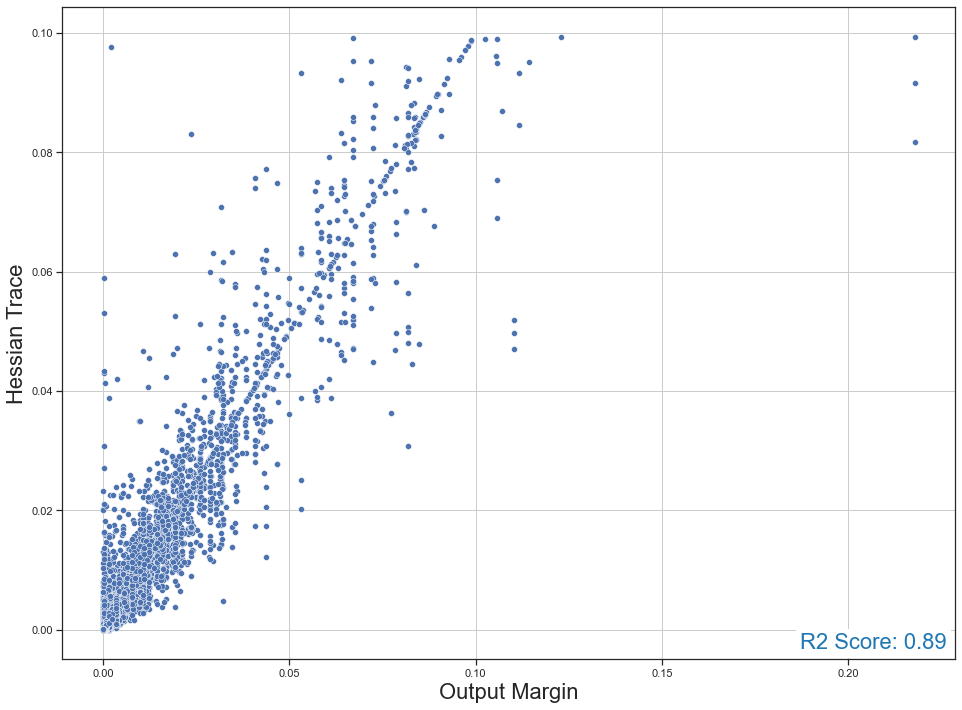

In [365]:
loss_type = "CE"

if loss_type == "CE":
    exp_name = ce_exp
    x_data = ce_all_x_data
    y_data = ce_all_y_data
else:
    exp_name = mse_exp
    x_data = mse_all_y_data
    y_data = mse_all_x_data
    

    
c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))


sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
# ax1.set_ylim(0, 1000)
# ax1.set_xlim(0, 1000)

print(mf_post.correlation.get_kendall(x_data, y_data).correlation)
ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="R2 Score: {:.2f}".format(r2_score(y_data, x_data)) ,\
         fontsize=22, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=2)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 0, 5000, 0, 5000
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/isotonic_all_points_{}_{}".format(exp_name, data_name), dpi=300, bbox_inches = "tight",)

# Plot accuracy vs correlation

In [12]:
ce_all_point_traces, _ = mf.save_load.load_cached_data(ce_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
ce_all_point_output_margins, _ = mf.save_load.load_cached_data(ce_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_20-51-39")


mse_all_point_traces, _ = mf.save_load.load_cached_data(mse_experiment_folder, "point_traces", step=-1, time_stamp="Dec02_14-40-03")
mse_all_point_output_margins, _ = mf.save_load.load_cached_data(mse_experiment_folder, "output_margins", step=-1, time_stamp="Dec02_18-53-57")


In [47]:

num_nets = 1

ce_kendall_coeffs_train_acc_dict = {}
ce_kendall_coeffs_test_acc_dict = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Train Mean"][exp_id])
        ce_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, ce_stats_df["Acc Test Mean"][exp_id])

mse_kendall_coeffs_train_acc_dict = {}
mse_kendall_coeffs_test_acc_dict = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = mse_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = mse_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        mse_kendall_coeffs_train_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Train Mean"][exp_id])
        mse_kendall_coeffs_test_acc_dict[exp_id] = (mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation, mse_stats_df["Acc Test Mean"][exp_id])

ce_kendall_coeffs_train_acc_arr = np.array(list(ce_kendall_coeffs_train_acc_dict.values()))
mse_kendall_coeffs_train_acc_arr = np.array(list(mse_kendall_coeffs_train_acc_dict.values()))
ce_kendall_coeffs_test_acc_arr = np.array(list(ce_kendall_coeffs_test_acc_dict.values()))
mse_kendall_coeffs_test_acc_arr = np.array(list(mse_kendall_coeffs_test_acc_dict.values()))

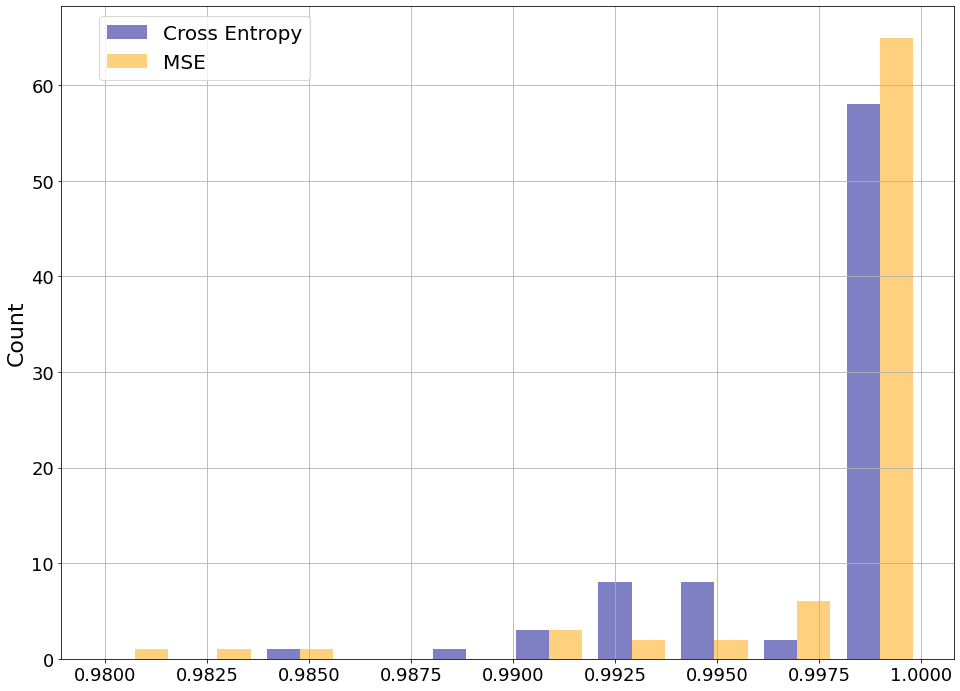

In [53]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_train_acc_arr[:, 1], mse_kendall_coeffs_train_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Training Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/train_acc", dpi=300, bbox_inches = "tight",)

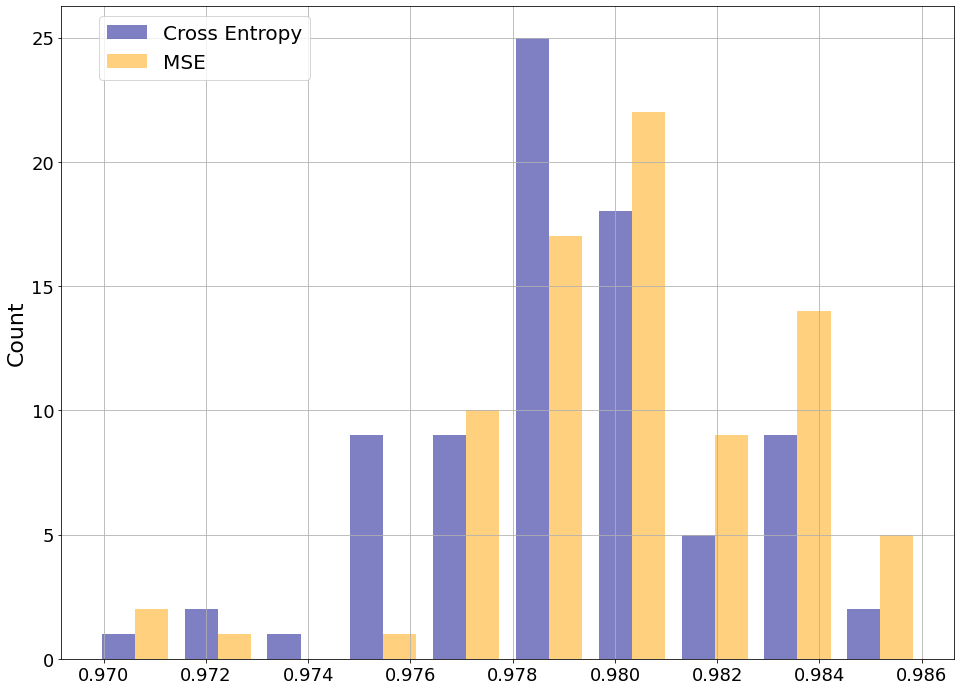

In [54]:
import seaborn as sns
f, (ax1_hist) = plt.subplots(1, figsize=(16,12))

ax1_hist.hist([ce_kendall_coeffs_test_acc_arr[:, 1], mse_kendall_coeffs_test_acc_arr[:, 1]], color=['darkblue','orange'], alpha=0.5, label=["Cross Entropy", "MSE"])

ax1_hist.grid(b=True, which='major')

ax1_hist.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1_hist.set_ylabel(ylabel="Test Accuracy", fontsize=22)

ax1_hist.set_ylabel(ylabel="Count", fontsize=22)

f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.35, 0.88))

f.savefig("../figs/test_acc", dpi=300, bbox_inches = "tight",)

# Scratch

In [146]:

num_nets = 1

ce_r2_coeffs_point_output = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_r2_coeffs_point_output[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


ce_r2_coeffs_point_loss = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_point_loss[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")

        
ce_r2_coeffs_output_margins = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        ce_r2_coeffs_output_margins[exp_id] = mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto")


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

In [441]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_all_point_traces[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_all_point_loss[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

mse_test_acc_hess = {}
for exp_id in mse_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
#         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(mse_all_point_loss[exp_id]["{}".format(nn_idx)])]#mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

-0.18939744269081046
0.2441076341959021


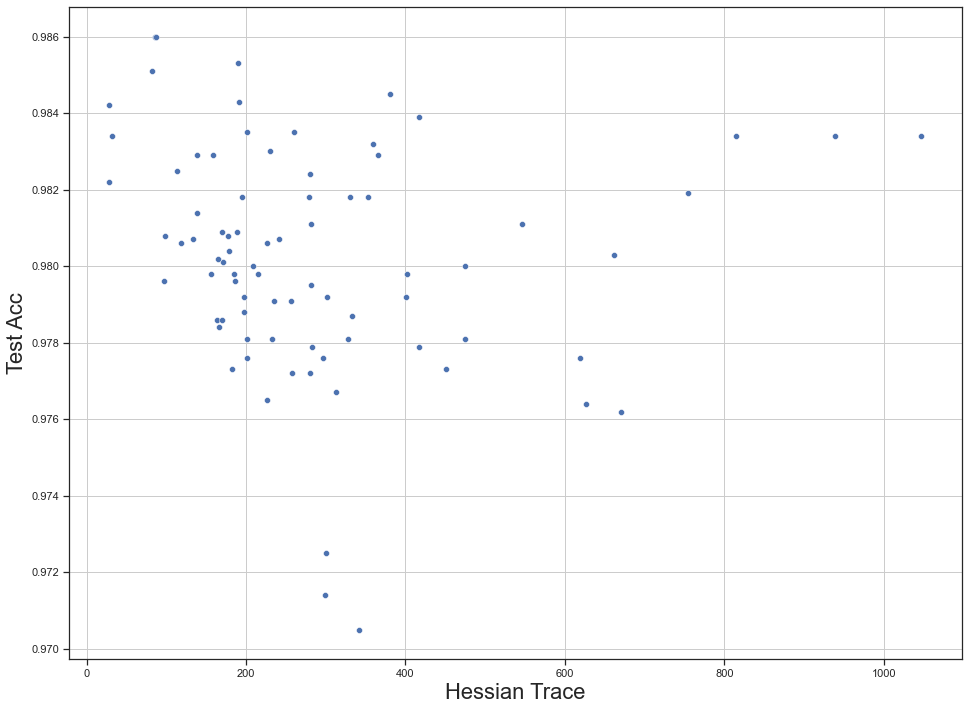

In [440]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]

print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

-0.17909076695302922
0.2794703697441018


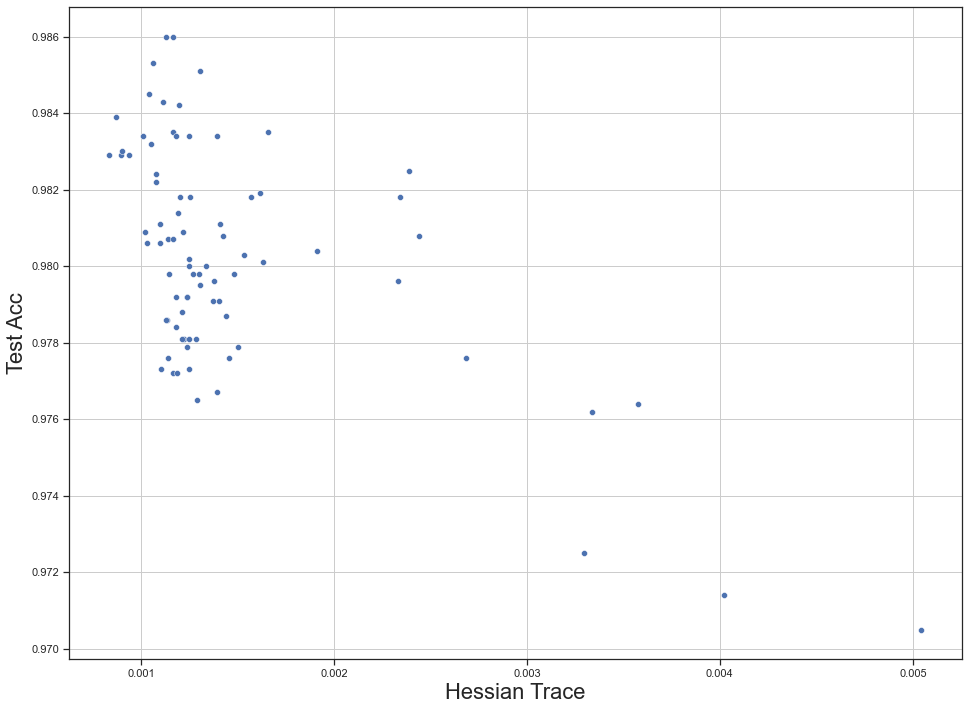

In [442]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = mse_test_acc_hess_arr[:, 1]
y_data = mse_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [185]:


ce_sample_flatness_old, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr07_18-31-05")
ce_sample_flatness, _ = mf.save_load.load_cached_data(ce_experiment_folder, "sample_average_flatness_pointwise", step=-1, time_stamp="Apr08_01-23-18")



-0.2756043507513157
0.6940995507677117


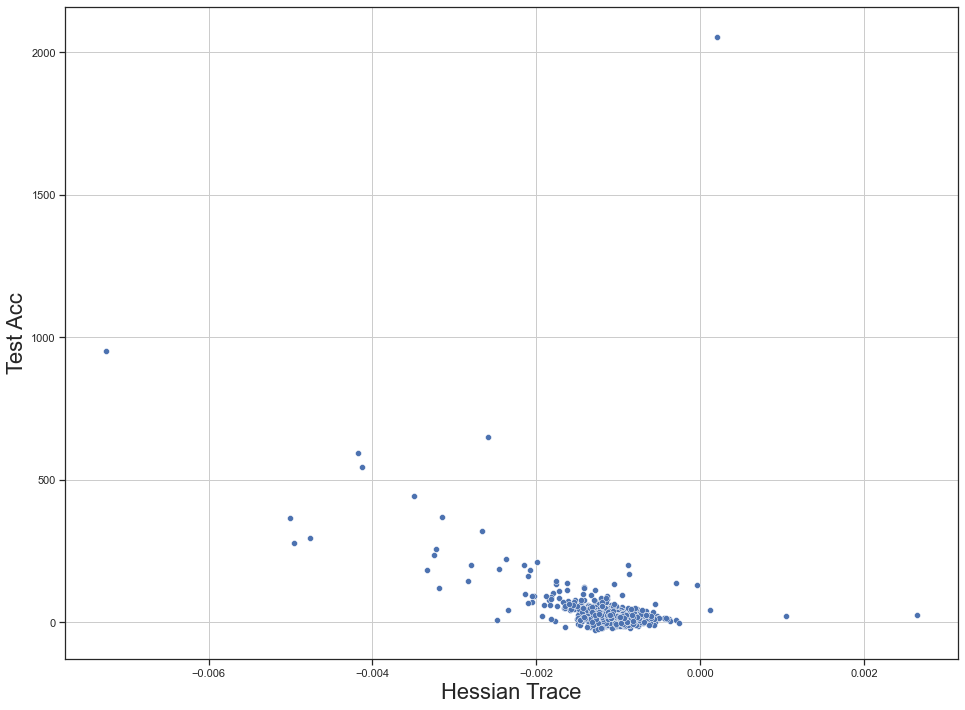

In [188]:
exp_id = list(ce_sample_flatness_old.keys())[0]
sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_sample_flatness[exp_id]['0']
y_data = ce_all_point_traces[exp_id]['0']
# y_data = ce_sample_flatness_old[exp_id]['0']
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [67]:

num_nets = 1

ce_test_acc_hess = {}
for exp_id in ce_stats_df.index:
    for nn_idx in range(num_nets):
        x_data = np.array(ce_sample_flatness[exp_id]["{}".format(nn_idx)])
        y_data = np.array(ce_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
        ce_test_acc_hess[exp_id] = [ce_stats_df.loc[exp_id]["Acc Test Mean"], np.mean(ce_sample_flatness[exp_id]["{}".format(nn_idx)])]

ce_test_acc_hess_arr = np.array(list(ce_test_acc_hess.values()))

# mse_test_acc_hess = {}
# for exp_id in mse_stats_df.index:
#     for nn_idx in range(num_nets):
#         x_data = np.array(mse_all_point_traces[exp_id]["{}".format(nn_idx)])
# #         y_data = np.array(mse_all_point_output[exp_id]["{}".format(nn_idx)])[:, 0]
#         mse_test_acc_hess[exp_id] = [mse_stats_df.loc[exp_id]["Acc Test Mean"], mse_stats_df.loc[exp_id]["Loss Train Mean"]] #np.mean(ce_all_point_traces[exp_id]["{}".format(nn_idx)])]

# mse_test_acc_hess_arr = np.array(list(mse_test_acc_hess.values()))

-0.028159666101149356
0.031682753519293394


/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "


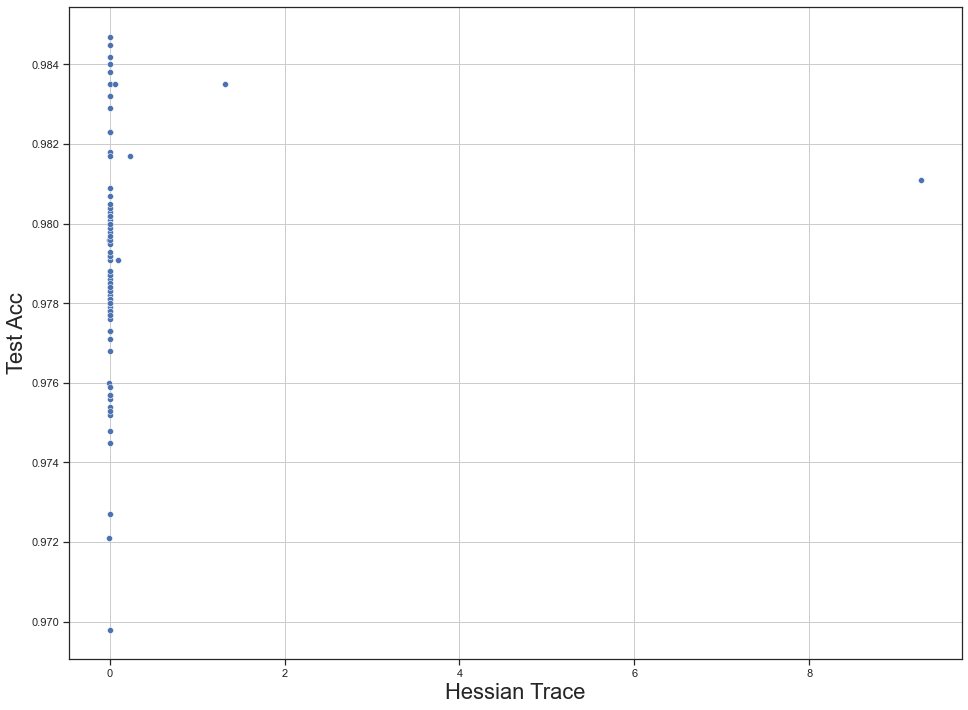

In [68]:

sns.set(style="ticks")

c1 = [1.        , 0.49803922, 0.05490196, 1.        ]
c2 = [0.12156863, 0.46666667, 0.70588235, 1.        ]


f, ax1 = plt.subplots(1, figsize=(16,12))

x_data = ce_test_acc_hess_arr[:, 1]
y_data = ce_test_acc_hess_arr[:, 0]
print(mf_post.correlation.get_kendall(x_data, y_data, remove_outliers=True).correlation)
print(mf_post.correlation.get_isotonic_r_squared(x_data, y_data, remove_outliers=True, increasing="auto"))
sns.scatterplot(x=x_data, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

# ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

ax1.set_ylabel(ylabel="Test Acc", fontsize=22)
ax1.set_xlabel(xlabel="Hessian Trace", fontsize=22)
# ax1.set_ylim(-250, 3500)


# ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="Kendall Coeff: {:.2f}".format(exp_kendall) ,\
#          fontsize=22, verticalalignment='top', horizontalalignment='right',\
#         backgroundcolor='white', color=c2)

ax1.grid(b=True, which='major')

# axins2 = inset_axes(ax1, width=4, height=4, loc=1)
# sns.scatterplot(x=x_data, y=y_data, ax=axins2)

# # sub region of the original image
# x1, x2, y1, y2 = 10, 16, -0.6, 1
# axins2.set_xlim(x1, x2)
# axins2.set_ylim(y1, y2)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax1, axins2, loc1=2, loc2=4, fc="none", ec="0.5")


#f.legend(loc="upper right", fontsize=20, bbox_to_anchor=(0.4, 0.88))


# f.savefig("../figs/subset_kendall_{}_{}_{}".format(id_type, data_name, ce_exp), dpi=300, bbox_inches = "tight",)

In [289]:
np.argmax([0,1,2])

2

In [297]:
def isotonic_outlier_removal(x_data, y_data, percent_outlier_remove=0.05, increasing="auto"):
    num_outlier_remove = int(len(x_data)*percent_outlier_remove)
    for _ in range(num_outlier_remove):
        iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        idx_max = np.argmax(np.abs(y_predicted - y_data))
        x_data = np.delete(x_data, idx_max)
        y_data = np.delete(y_data, idx_max)
    return x_data, y_data


def get_isotonic_r_squared(x_data, y_data, remove_outliers=False, increasing=False):
    if len(x_data) == 0:
        return 0, 0, 0, None, None
    x_data, y_data = np.array(x_data), np.array(y_data)

    if remove_outliers:
        outlier_filter = get_outlier_filter(x_data, y_data)
        x_data, y_data = x_data[outlier_filter], y_data[outlier_filter]
        
    iso_reg = IsotonicRegression(increasing=increasing).fit(x_data, y_data)
    y_predicted = iso_reg.predict(x_data)
    return r2_score(y_data, y_predicted)


In [376]:
slopes = []
weights = []

ce_models = mf.save_load.get_all_models(ce_experiment_folder, step=-1, device=None)

num_nets = 1

ce_all_x_data = []
ce_all_y_data = []
counter = 0
for exp_id in ce_stats_df.index:
    if counter > 100:
        break
    counter += 1
    for nn_idx in range(num_nets):
        x_data = ce_all_point_traces[exp_id]["{}".format(nn_idx)]
        y_data = ce_all_point_loss[exp_id]["{}".format(nn_idx)] #ce_all_point_output_margins[exp_id]["{}".format(nn_idx)]
        x_data, y_data = isotonic_outlier_removal(x_data, y_data, 0.02)
        iso_reg = IsotonicRegression(increasing="auto").fit(x_data, y_data)
        y_predicted = iso_reg.predict(x_data)
        y_predicted_org = np.copy(y_predicted)
        y_predicted += (x_data - np.min(x_data)) * 0.00002 / np.linalg.norm(x_data) * np.linalg.norm(y_data)

        slope, intercept, correct_r_value, _, _ = mf_post.correlation.linregress_outliers(x_data, y_data)
        y_lin_predicted = np.array(x_data) * float(slope) + intercept

        slopes.append(slope)
        weights.append(mf.utils.get_params_norm(ce_models[exp_id]["0"]))

#         ce_all_x_data.append(np.mean(x_data))
#         ce_all_y_data.append(np.max(y_data))
        
# ce_all_x_data = np.array(ce_all_x_data).flatten()
# ce_all_y_data = np.array(ce_all_y_data).flatten()
     
# exp_name = ce_exp
# x_data = ce_all_x_data
# y_data = ce_all_y_data


    
#         c1 = [1.        , 0.49803922, 0.05490196, 1.        ]


#         f, ax1 = plt.subplots(1, figsize=(16,12))
        
#         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=x_data, y=y_data)
# #         sns.scatterplot(x=y_lin_predicted, y=y_data)
# #         sns.scatterplot(x=y_predicted, y=y_data, ax=ax1) #, label="Kendall Coeff: {:.2f}".format(exp_kendall))

#         # ax1.tick_params(axis='both', labelbottom=True, labelsize=18)

#         ax1.set_ylabel(ylabel="Hessian Trace", fontsize=22)
#         ax1.set_xlabel(xlabel="Output Margin", fontsize=22)
#         # ax1.set_ylim(-50, 300)
        
#         print(mf_post.correlation.get_kendall(y_predicted, y_data).correlation)
#         print(mf_post.correlation.get_kendall(y_lin_predicted, y_data).correlation)

#         print(mf_post.correlation.get_kendall(x_data, y_data).correlation)
#         ax1.text(x=0.99, y=0.04, transform=ax1.transAxes, s="R2 Score: {:.2f}".format(r2_score(y_data, y_lin_predicted)) ,\
#              fontsize=22, verticalalignment='top', horizontalalignment='right',\
#             backgroundcolor='white', color=c2)

#         ax1.grid(b=True, which='major')
#         plt.show()
        

/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
/Users/daniellengyel/miniconda3/envs/gen/lib/python3.8/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coe

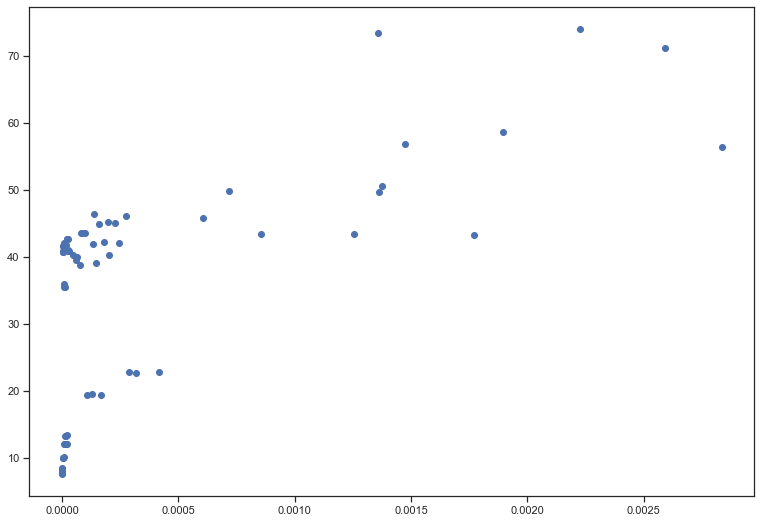

In [377]:
plt.scatter(slopes, weights)

In [265]:
ce_models = mf.save_load.get_all_models(ce_experiment_folder, step=-1, device=None)



In [126]:
def compare_nets(m1, m2, N, inp_dim, seed=0):
    x = torch.randn(N, inp_dim)
    y1 = m1(x)
    y2 = m2(x)
    diff = torch.norm(y1 - y2, dim=1)
    return float(torch.mean(diff).detach().numpy())

m1 = ce_models[ce_stats_df.index[0]]["0"]
m2 = ce_models[ce_stats_df.index[1]]["0"]

N = 100
inp_dim = 28*28

# ce_stats_df.index[0]

arr_dists = []
for i in range(81):
    for j in range(i, 81):
        arr_dists.append(compare_nets(ce_models[ce_stats_df.index[i]]["0"], ce_models[ce_stats_df.index[j]]["0"], N, inp_dim, seed=0))

# compare_nets(m1, m2, 1000, 28*28)


# for exp_id in ce_stats_df.index:
#     for exp_id in ce_stats_df.index:

KeyboardInterrupt: 

In [162]:
import torch

seed = 0
num_datapoints = 100

m1 = ce_models[ce_stats_df.index[0]]["0"]


train_data, test_data = mf.postprocessing.utils.get_data_for_experiment(ce_experiment_folder)
data = mf.data_getters.get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)

data_loader = DataLoader(data, batch_size=1, shuffle=False)


m1.eval()

res = []

for i, (inputs, labels) in enumerate(data_loader):

    outputs = m1(inputs) # get softmax of this 
    temp_res = []
    soft_layer = torch.nn.Softmax(dim=-1)
    for a in np.linspace(1, 1.5):
        temp_res.append(max(soft_layer(a*outputs).detach().numpy()[0]))
    res.append(temp_res)

In [163]:
int_arr = []
for i in range(len(res)):
    for j in range(i+1, len(res)):
        int_arr.append(do_intersect(res[i], res[j]))
        if int_arr[-1]:
            print("{} {}".format(i, j))
        
# int_arr

0 49
3 54
4 69
5 30
5 79
6 20
6 51
6 80
6 90
7 36
8 49
8 50
9 26
10 30
12 78
12 96
14 16
14 22
14 27
14 86
15 50
16 86
16 89
17 53
17 57
19 21
19 37
21 37
22 27
22 99
25 49
26 85
27 89
27 99
29 47
29 87
29 92
29 95
30 79
36 43
41 46
41 72
42 61
46 72
47 66
47 70
47 92
48 71
48 82
49 50
51 80
51 90
53 57
59 61
59 91
61 77
64 78
65 76
66 87
66 92
66 95
67 71
70 87
70 92
70 95
80 90
84 87
84 94
86 89
86 99
92 95


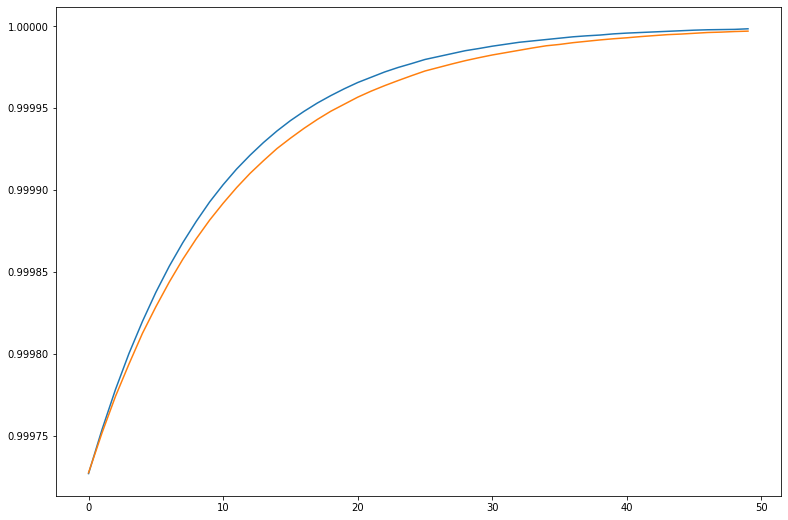

In [168]:
plt.plot(res[48])
plt.plot(res[71])
# plt.xlim(40, 50)

In [413]:
arr_dists = np.array([np.array(dict_dists[i]) for i in range(81)])

In [154]:
def do_intersect(res1, res2):
    for i in range(len(res1)):
        if res1[0] < res2[0]:
            if res1[i] > res2[i]:
                return True
        if res1[0] > res2[0]:
            if res1[i] < res2[i]:
                return True
    return False

In [111]:
import numpy as np

delta = 2
for _ in range(100):
    a = np.random.random(10)
    a[0] = delta*max(a)


    res1 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res1.append(o.dot(o))

    res1 = np.array(res1)


    a = np.random.random(10)
    a[0] = delta*max(a)

    res2 = []
    for i in np.linspace(0, 100):
        o = np.exp(i*a) / np.sum(np.exp(i*a))
        res2.append(o.dot(o))

    res2 = np.array(res2)
    print(do_intersect(res1, res2))

False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
True
False
False
True
True
True
False
True
False
False
False
True
False
False
False
False
True
False
True
True
False
False
False
False
True
False
True
False
True
False
False
True
False
False
False
True
False
False
False
True
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
True
False
False
False
